In [1]:
import pandas as pd
from data_pipeline.dataset import Dataset

In [2]:
df = pd.read_feather("../../data/parquet_files/train/processed_train.feather")
df.head()

,case_id,target,numberofcontrsvalue_358L_max_0,nominalrate_281L_min_0,classificationofcontr_400M_mode_0,numberofcontrsvalue_358L_max_1,nominalrate_281L_min_1,classificationofcontr_400M_mode_1,numberofcontrsvalue_358L_max_2,nominalrate_281L_min_2,classificationofcontr_400M_mode_2,numberofcontrsvalue_358L_max_3,nominalrate_281L_min_3,classificationofcontr_400M_mode_3,credacc_cards_status_52L_mode_0,credacc_cards_status_52L_last_0,last180dayaveragebalance_704A_last_0,last180dayaveragebalance_704A_mean_0,last180dayaveragebalance_704A_max_0
0,0,0,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN
1,1,0,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN
2,2,0,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN
3,3,0,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN
4,4,1,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN


In [3]:
from hydra.utils import instantiate
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from data_pipeline.pipelinesteps import data_splitter


GlobalHydra.instance().clear()
initialize(config_path="../../", version_base=None)
cfg = compose(config_name="config")

data_pipeline = instantiate(cfg.data_pipeline)
df = pd.read_feather("../../data/parquet_files/train/processed_train.feather")
df = data_pipeline.apply(df)

dataset = Dataset(data=df, data_splitter=data_splitter, target_column='target')



In [4]:

dataset.shape

(1526659, 677)

In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load a binary classification dataset



# Split the data into training and test sets
X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test 

# Train a HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

# Predict the probabilities of the positive class
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score: {auc_score}")

AUC score: 0.626309568759873


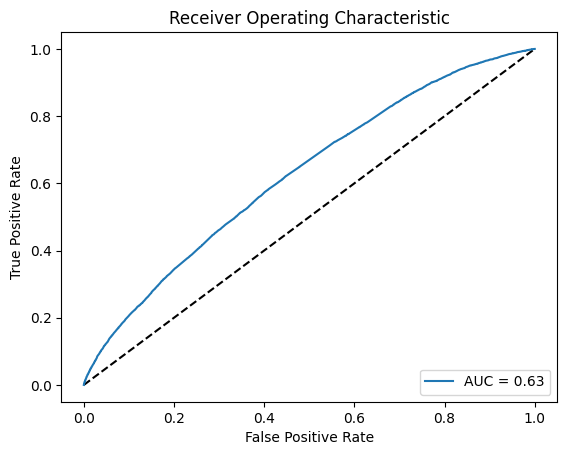

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# Plot the AUC score
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [7]:
def second():
    try:
        print("third_function")
        print(1/0)
    except Exception as error:
        error_message = str(error).split("\n")[0]
        raise ValueError(error_message)
    
def first():
    try:
        print("second_function")
        second()
    except Exception as error:
        error_message = str(error).split("\n")[0]
        return ValueError(error_message) 

In [8]:
first()

second_function
third_function


ValueError('division by zero')